In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
g = 9.81
z = 257.4 * 0.001
Tc = np.sqrt(z/g)
# supporting duration
T_sup = 0.6

In [4]:
def calc_basic_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)-1) / np.sinh(T_sup/Tc)

def calc_y_vel(y0, T_sup):
    return (y0/Tc) * ( np.sinh(T_sup/Tc) / ( -1 - np.cosh(T_sup/Tc) ) )

In [5]:
def calc_LIP_p(t, cp0, cv0):
    x_t = cp0[0] * np.cosh(t/Tc) + Tc * cv0[0] * np.sinh(t/Tc)
    y_t = cp0[1] * np.cosh(t/Tc) + Tc * cv0[1] * np.sinh(t/Tc)
    return [x_t, y_t]

def calc_LIP_v(t, cp0, cv0):
    vx_t = cp0[0] / Tc * np.sinh(t/Tc) + cv0[0] * np.cosh(t/Tc)
    vy_t = cp0[1] / Tc * np.sinh(t/Tc) + cv0[1] * np.cosh(t/Tc)
    return [vx_t, vy_t]

def calc_LIP_com(T_sup, cp0, cv0):
    n = int(T_sup / 0.01) + 1

    traj = []

    for i in range(n):
        t = i * 0.01
        pos = calc_LIP_p(t, cp0, cv0)
        traj.append(pos)

    return traj

In [6]:
kp = 0.01
kd = 0.001

def px_pid(cvn_last, cvn_m1_last, vd):
    print(f"cvn_m1_last: {cvn_m1_last}, cvn_last: {cvn_last}")
    err = vd-cvn_last[0]
    derr = -cvn_last[0] + cvn_m1_last[0]
    # print(f"vel err: {err}, d_err: {derr}")

    px = calc_basic_foot_pos(cvn_last[0], T_sup)
    # print("basic foot pos x:", px)

    px_r = px - kp * err - kd * derr

    # print("corrected foot pos x:", px_r)
    return px_r

In [11]:
# com, pn: com and foot position from current foot position
cpn_last = [0, -0.03]
cvn_last = []

pn = [0,-0.03]

cvn_m1_last = [0, calc_y_vel(-pn[1], T_sup)]
cvn_last = calc_LIP_v(T_sup, [-pn[0], -pn[1]], cvn_m1_last)
print(cvn_last)

[0.0, 0.1763032118276362]


In [12]:
vd = 0.15
foot_pos = []
traj_history = []

for i in range(12):
    if i < 4:
        vd = 0.25
    elif i < 6:
        vd = 0.15
    elif i < 9:
        vd = -0.1
    else:
        vd = 0.0

    # decide pn_p1
    px_p1 = px_pid(cvn_last, cvn_m1_last, vd)
    pn_p1 = [px_p1, -pn[1]]
    print("next foot pos pn_p1:", pn_p1)
    foot_pos.append(pn_p1)

    # calculate COM trajectory
    # from: n step com last, pivot: pn_p1
    cp0 = [-pn_p1[0], -pn_p1[1]]
    cv0 = cvn_last
    traj = calc_LIP_com(T_sup, cp0, cv0)
    traj_history.append(traj)

    # update com and p
    pn = pn_p1
    cvn_m1_last = cvn_last
    cpn_last = calc_LIP_p(T_sup, cp0, cv0)
    cvn_last[0] = calc_LIP_v(T_sup, cp0, cv0)[0]
    cvn_last[1] = -1 * cvn_m1_last[1]
    print("-------------------")


cvn_m1_last: [0, -0.17630321182763578], cvn_last: [0.0, 0.1763032118276362]
next foot pos pn_p1: [-0.0025, 0.03]
-------------------
cvn_m1_last: [0.31321498773788276, -0.1763032118276362], cvn_last: [0.31321498773788276, -0.1763032118276362]
next foot pos pn_p1: [0.04892924829509225, -0.03]
-------------------
cvn_m1_last: [0.23401546130119666, 0.1763032118276362], cvn_last: [0.23401546130119666, 0.1763032118276362]
next foot pos pn_p1: [0.035924851093721004, 0.03]
-------------------
cvn_m1_last: [0.25404184967136256, -0.1763032118276362], cvn_last: [0.25404184967136256, -0.1763032118276362]
next foot pos pn_p1: [0.039213142332214124, -0.03]
-------------------
cvn_m1_last: [0.2489779780903456, 0.1763032118276362], cvn_last: [0.2489779780903456, 0.1763032118276362]
next foot pos pn_p1: [0.039381665170934325, 0.03]
-------------------
cvn_m1_last: [0.12497243331479346, -0.1763032118276362], cvn_last: [0.12497243331479346, -0.1763032118276362]
next foot pos pn_p1: [0.01902021312711598,

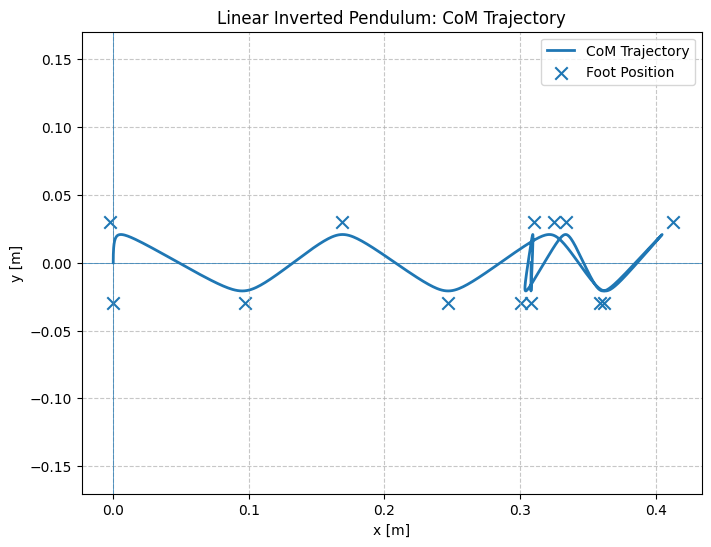

In [13]:
foot_all = [[0,-0.03]]
traj_all = []
traj_last = [0,0]
for i in range(len(foot_pos)):
    # convert to world coordinate
    pivot = [0,0]
    pivot[0] = foot_pos[i][0] + traj_last[0]
    pivot[1] = foot_pos[i][1] + traj_last[1]
    traj = traj_history[i]

    for pos in traj:
        traj_all.append([pos[0]+pivot[0], pos[1]+pivot[1]])
    traj_last = traj_all[-1]
    foot_all.append(pivot)

# CoM trajectory
x_coords = [pos[0] for pos in traj_all]
y_coords = [pos[1] for pos in traj_all]

# Foot positions
foot_x = [pos[0] for pos in foot_all]
foot_y = [pos[1] for pos in foot_all]

# 2. グラフの設定
plt.figure(figsize=(8, 6))

# CoM
plt.plot(x_coords, y_coords,
         label='CoM Trajectory',
         linewidth=2)

# Foot (pivot)
plt.scatter(foot_x, foot_y,
            marker='x',
            s=80,
            label='Foot Position')

# 3. 装飾
plt.title('Linear Inverted Pendulum: CoM Trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.axis('equal')

# 4. 表示
plt.show()
